In [0]:
!nvidia-smi

Fri Jun 12 19:33:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   4705MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os, shutil, sys
from datetime import datetime

import numpy as np, scipy as sp, pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import# Importing Deep Learning Libraries
ls = ['tensorflow','h5py','sklearn']

for i in ls:
    exec('import {0}'.format(i))
    exec('print("Version of {0}",{0}.__version__)'.format(i))

Version of tensorflow 2.2.0
Version of h5py 2.10.0
Version of sklearn 0.22.2.post1


In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.datasets import mnist, cifar10, cifar100, fashion_mnist, imdb, reuters

from tensorflow.keras import backend as K

In [0]:
# Sentence classification dataset
max_features, maxlen, test_split = 20000, 100, 0.2

# Embedding
embedding_size = 128

# LSTM
lstm_output_size = 70

# Convolution_1d
filters_1d, kernel_size_1d, pool_size_1d = 64, 5, 4

# Convolution_2d
filters_2d, kernel_size_2d, pool_size_2d = 64, 3, 2

In [0]:
def get_data(dataset='mnist'):
    print(dataset)
    if dataset in ('imdb','reuters'):
        if dataset=='imdb':
            (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
        elif dataset=='reuters':
            (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features, test_split=test_split, seed=42)
        x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
        x_test  = sequence.pad_sequences(x_test, maxlen=maxlen)
        print(len(x_train), len(x_test))
    else:
        (x_train, y_train), (x_test, y_test) = eval('{}.load_data()'.format(dataset))
    for name, mat in zip( ('x_train', 'y_train', 'x_test', 'y_test') , (x_train, y_train, x_test, y_test) ):
        print(name, mat.dtype, mat.min(), mat.max())
    return (x_train, y_train), (x_test, y_test)

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [6]:
_ = get_data('fashion_mnist')

fashion_mnist
x_train uint8 0 255
y_train uint8 0 9
x_test uint8 0 255
y_test uint8 0 9


In [0]:
class NN:
    "Class for creating Variety of CNN architectures, and choose to experiment on them"

    def __init__(self, dataset, model_choice=0):        
        # The data, split between train and test sets:
        (self.x_train, self.y_train), (self.x_test, self.y_test) = get_data(dataset)
        if len(self.x_train.shape)==3:
            self.x_train, self.x_test = self.x_train[:,:,:,np.newaxis], self.x_test[:,:,:,np.newaxis]
        # print(self.x_train.shape)
        self.x_train, self.x_test = self.x_train.astype('float32')/255, self.x_test.astype('float32')/255
        self.num_classes = len(set(np.ravel(self.y_train))|set(np.ravel(self.y_test)))
        self.y_train = tensorflow.keras.utils.to_categorical(self.y_train, self.num_classes)
        self.y_test  = tensorflow.keras.utils.to_categorical(self.y_test , self.num_classes)
        # Model definition for different choices
        self.compiled, self.prob_vec = False, None
        self.dataset, self.model_choice = dataset, model_choice
        self.build_model(self.model_choice)
    
    def build_model(self, model_choice):
        self.model = Sequential()
        self.model_choice = model_choice
        if model_choice==0:
            self.model.add(Conv2D(filters_2d, (kernel_size_2d, kernel_size_2d), padding='same', input_shape=self.x_train.shape[1:]))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(filters_2d, (kernel_size_2d, kernel_size_2d), padding='same'))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(pool_size_2d, pool_size_2d)))
            self.model.add(Dropout(0.25))
            self.model.add(Conv2D(2*filters_2d, (kernel_size_2d, kernel_size_2d), padding='same'))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(2*filters_2d, (kernel_size_2d, kernel_size_2d), padding='same'))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(pool_size_2d, pool_size_2d)))
            self.model.add(Dropout(0.25))
            self.model.add(Flatten())
            self.model.add(Dense(1024))
            self.model.add(Activation('relu'))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(self.num_classes))
            self.model.add(Activation('softmax'))
        elif model_choice==1:
            self.model.add(Embedding(max_features, embedding_size, input_length=maxlen))
            self.model.add(Dropout(0.25))
            self.model.add(Conv1D(filters=filters_1d, kernel_size=kernel_size_1d,activation='relu',strides=1))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling1D(pool_size=pool_size_1d))
            self.model.add(Bidirectional(LSTM(lstm_output_size)))
            self.model.add(Dense(self.num_classes))
            self.model.add(Activation('softmax'))

    def compile(self, opt='Adam', lr=0.01, decay=0):
        # Selcting optimizer and compiling model
        self.build_model(self.model_choice)
        opt = eval('tensorflow.keras.optimizers.{}(learning_rate={})'.format(opt, lr))
        self.model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy',
                                                                                    tensorflow.keras.metrics.top_k_categorical_accuracy])
        self.model.my_metrics_names = ['loss', 'accuracy', 'val_loss', 'val_accuracy', 'top_k', 'val_top_k']
        self.compiled = True
    
    def update_prob(self, data_ix):
        y_true, y_pred = self.y_train[data_ix], self.model.predict_on_batch(self.x_train[data_ix])
        old_prob = self.prob_vec[data_ix]
        scores = -1*(y_true*(1-np.exp(y_pred)) + (1-y_true)*(1-np.exp(1-y_pred))).sum(axis=1)
        scores = 1/scores
        zipped_ls = np.array(sorted(zip(data_ix, scores), key=lambda x:x[1])).T
        cumsum = np.cumsum(zipped_ls[1])
        new_prob = (self.prob_vec[data_ix].sum())*(cumsum/cumsum.sum())
        if (new_prob<=0.0).any():
            print(data_ix, self.prob_vec[data_ix], new_prob, sep='\n')
        ordrd_data_ix = zipped_ls[0].round().astype('int')
        self.prob_vec[ordrd_data_ix] = (self.sampling_rate)*new_prob + (1-self.sampling_rate)*old_prob 

    def fit(self, opt='Adam', lr=0.01, decay=0.0, test_batch_size=32,
              train_batch_size=64, epochs=300, steps_per_epoch=None, recompile = True,
              use_sampling=True, update_sampling=True, reset_sampling=True, sampling_rate=None, sampling_relax_epochs=0, sampling_relax_steps=0, 
              callbacks = [], verbose=1
            ):
        "Method for Training Neural Network build within class"
        if self.compiled or recompile:
            # self.build_model(self.model_choice)
            self.compile(opt=opt, lr=lr, decay=decay)
        if self.prob_vec is None or reset_sampling:
            self.prob_vec = np.ones(self.x_train.shape[0]) / self.x_train.shape[0]
        self.sampling_rate = train_batch_size / self.x_train.shape[0] if sampling_rate is None else sampling_rate

        # Training data with or without data augmentation, depending upon user input
        self.history = {}
        for key in self.model.my_metrics_names:
            self.history[key] = []
        self.train_itr_count = 0
        for callback in callbacks:
            pass
            # callback.on_train_begin(self, logs = self.history)

        for epoch_ix in range(epochs):
            if verbose:
                print('Epoch {0}/{1}'.format(epoch_ix+1,epochs), end=' ')
            if steps_per_epoch is None:
                steps_per_epoch = int(np.ceil(self.x_train.shape[0]/train_batch_size))
            for batch_ix in range(steps_per_epoch):
                if use_sampling:
                    data_ix = np.random.choice(self.x_train.shape[0], size=train_batch_size, replace=False, p=self.prob_vec)
                else:
                    data_ix = np.random.choice(self.x_train.shape[0], size=train_batch_size, replace=False)
                x_batch, y_batch = self.x_train[data_ix], self.y_train[data_ix]
                loss, accuracy, top_k = self.model.train_on_batch(x_batch, y_batch, reset_metrics=(True if not batch_ix else False))
                if update_sampling and (steps_per_epoch*sampling_relax_epochs+sampling_relax_steps)<=self.train_itr_count:
                    self.update_prob(data_ix)
                self.train_itr_count += 1
            # Validation loss and metrics evaluation
            if test_batch_size is None:
                test_batch_size = self.x_test.shape[0]
            n_test_batches = int(np.ceil(self.x_test.shape[0]/test_batch_size))
            for batch_ix in range(n_test_batches):
                x = self.x_test[batch_ix*test_batch_size:(batch_ix+1)*test_batch_size]
                y = self.y_test[batch_ix*test_batch_size:(batch_ix+1)*test_batch_size]
                val_loss, val_accuracy, val_top_k = self.model.test_on_batch(x, y, reset_metrics=(True if not batch_ix else False))
                for callback in callbacks:
                    pass
            for key in self.model.my_metrics_names:
                self.history[key].append( eval(key) )
                if verbose:
                    print('{0} {1:8.6g},'.format(key,self.history[key][-1]), end=' ')
            print()
            if self.model.stop_training:
                break                  

    def evaluate(self,x_test, y_test):
        scores = self.model.evaluate(x_test, y_test, verbose=1)
        print('Evaluated loss:'     , scores[0])
        print('Evaluated accuracy:' , scores[1])

    def predict(self,x_test):
        return self.model.predict(x_test, verbose=1)

    def plot(self, metrics=['loss']):
        "Plotting either loss or accuracy metric for both training and validation data"
        fig, ax = plt.subplots(1, len(metrics), figsize=(4*len(metrics),5))
        fig.suptitle('Training Profile', size=28)
        for ix,metric in enumerate(metrics):
            for key in self.history:
                if metric in key:
                    ax[ix].plot(self.history[key],label=key)
            ax[ix].legend()
            ax[ix].grid(True, which='both')
            ax[ix].set_xlabel('Number of Epochs')
            ax[ix].set_ylabel('{} value'.format(metric))
        plt.show()

    def dist(self):
        sns.distplot(self.prob_vec)
    
    def imshow(self,asc=True, count=5, fixed = True, width=4):
        fig, ax = plt.subplots(int(np.ceil(count/width)), width, figsize=(3*width,1+3*int(np.ceil(count/width))))
        fig.suptitle('Image Subset {0}'.format('Best' if asc else 'Worst'), size=20)
        if fixed:
            show_ix = ((1 if asc else -1)*self.prob_vec).argsort()[:count]
        else:
            show_ix = np.random.choice(self.x_train.shape[0],size=count,replace=False, p = self.prob_vec)
        y_pred, y_true = self.predict(self.x_train[show_ix]), self.y_train[show_ix]
        print(show_ix)
        for ix in range(count):
            if self.x_train.shape[-1]==3:
                img = np.clip(self.x_train[show_ix[ix]]*255,0,255).astype('uint8')
            else:
                img = np.clip(self.x_train[show_ix[ix]]*255,0,255).astype('uint8')[:,:,0]
            ax[ix//width,ix%width].imshow(img)
            ax[ix//width,ix%width].set_title('Actual {0:d} Predicted {1:d}\n{2:6.3g}'.format(
                np.argmax(y_true[ix]), np.argmax(y_pred[ix]), self.prob_vec[show_ix[ix]]), size=14)
        plt.show()

In [8]:
model = NN('cifar10', model_choice=0)

cifar10
x_train uint8 0 255
y_train uint8 0 9
x_test uint8 0 255
y_test uint8 0 9


Epoch 1/30 loss  1.99588, accuracy 0.272319, val_loss  1.67439, val_accuracy 0.401585, top_k 0.767843, val_top_k 0.884029, 
Epoch 2/30 loss  1.53868, accuracy 0.441406, val_loss  1.35976, val_accuracy 0.501003, top_k 0.907267, val_top_k 0.936296, 
Epoch 3/30 loss  1.30835, accuracy 0.528076, val_loss  1.20411, val_accuracy 0.567516, top_k  0.94106, val_top_k 0.951344, 
Epoch 4/30 loss  1.16063, accuracy  0.58905, val_loss  1.11752, val_accuracy 0.603431, top_k 0.955872, val_top_k  0.95937, 
Epoch 5/30 loss  1.00843, accuracy 0.647095, val_loss 0.958123, val_accuracy 0.661517, top_k  0.96816, val_top_k 0.970807, 
Epoch 6/30 loss 0.918227, accuracy 0.674601, val_loss  0.90097, val_accuracy 0.682183, top_k 0.974915, val_top_k 0.974318, 
Epoch 7/30 loss 0.830319, accuracy 0.708598, val_loss 0.821021, val_accuracy 0.710574, top_k 0.980042, val_top_k 0.976826, 
Epoch 8/30 loss 0.768654, accuracy 0.729533, val_loss 0.774045, val_accuracy 0.726425, top_k 0.983459, val_top_k 0.980738, 
Epoch 9/

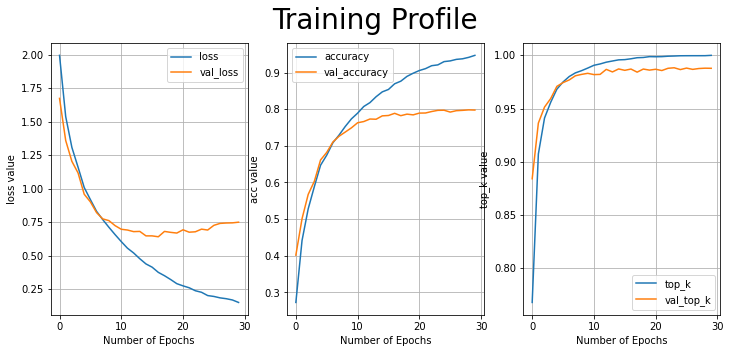

CPU times: user 3min 52s, sys: 1min 3s, total: 4min 56s
Wall time: 4min 43s


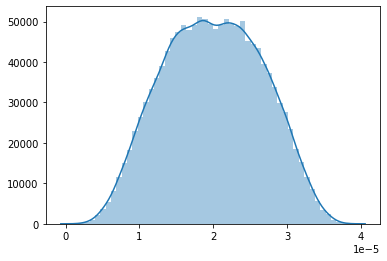

In [10]:
%%time
model.fit(opt='Adam', lr=0.001, decay=0.0, test_batch_size=32,
            train_batch_size=1024, epochs=30, steps_per_epoch=None, recompile = True,
            use_sampling=False, update_sampling=True, reset_sampling=True, sampling_rate=0.5, sampling_relax_epochs=0, sampling_relax_steps=0,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True),
                       ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=5, min_delta=1e-4, min_lr=1e-6, verbose=1)],
            verbose=1)
model.evaluate(model.x_test, model.y_test)
print(max(enumerate(model.history['val_accuracy']),key=lambda x:x[1]))
model.plot(['loss','acc','top_k'])
model.dist()

1/1 [==============================] - 0s 922us/step
[23374 26032   529 46941  7757 14758  6435 43113]


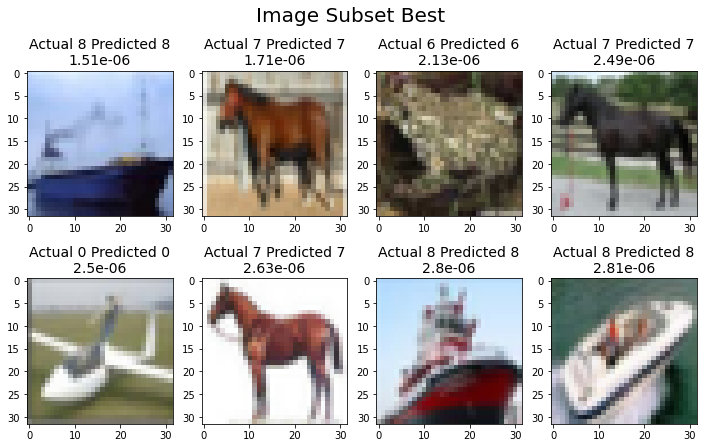

In [15]:
model.imshow(True,8, fixed=True)

1/1 [==============================] - 0s 827us/step
[19421 46931 12667 49404 20523 44379 20999 46568]


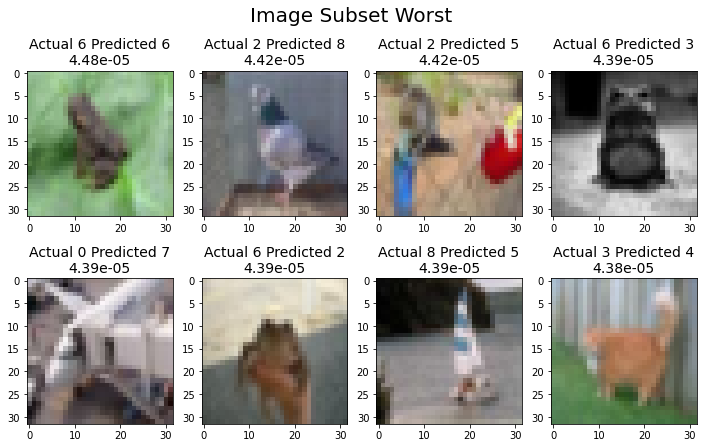

In [16]:
model.imshow(False,8,fixed=True)

Epoch 1/30 loss  2.03822, accuracy 0.241536, val_loss  1.68397, val_accuracy 0.393058, top_k 0.768819, val_top_k 0.883026, 
Epoch 2/30 loss  1.63825, accuracy 0.390544, val_loss  1.40229, val_accuracy 0.494683, top_k 0.896118, val_top_k 0.932584, 
Epoch 3/30 loss   1.4143, accuracy 0.479919, val_loss  1.22274, val_accuracy  0.55628, top_k 0.933838, val_top_k 0.951946, 
Epoch 4/30 loss  1.27681, accuracy 0.534281, val_loss  1.05617, val_accuracy 0.620285, top_k 0.950684, val_top_k 0.966292, 
Epoch 5/30 loss  1.17279, accuracy 0.576843, val_loss  1.01456, val_accuracy 0.642857, top_k 0.959188, val_top_k 0.968499, 
Epoch 6/30 loss   1.0471, accuracy  0.62144, val_loss 0.871077, val_accuracy 0.695626, top_k 0.970113, val_top_k 0.976525, 
Epoch 7/30 loss 0.965174, accuracy 0.653564, val_loss 0.859911, val_accuracy 0.699839, top_k 0.975505, val_top_k 0.977628, 
Epoch 8/30 loss 0.883597, accuracy 0.683594, val_loss 0.780701, val_accuracy 0.726726, top_k 0.980306, val_top_k 0.981441, 
Epoch 9/

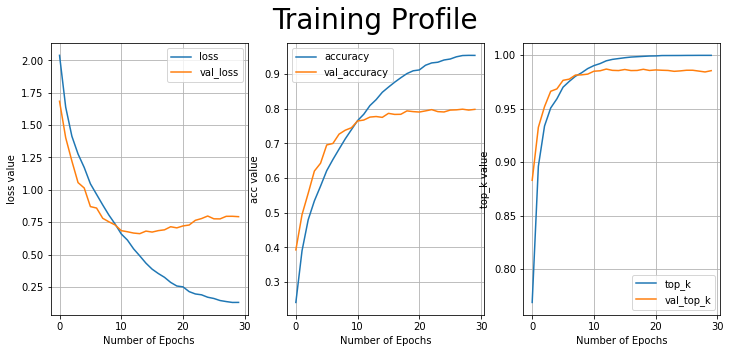

CPU times: user 2min 47s, sys: 50.1 s, total: 3min 37s
Wall time: 3min 29s


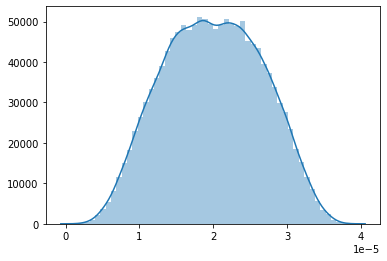

In [13]:
%%time
model.fit(opt='Adam', lr=0.001, decay=0.0, test_batch_size=32,
            train_batch_size=1024, epochs=30, steps_per_epoch=None, recompile = True,
            use_sampling=True, update_sampling=False, reset_sampling=False, sampling_rate=0.5, sampling_relax_epochs=0, sampling_relax_steps=0,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True),
                       ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=5, min_delta=1e-4, min_lr=1e-6, verbose=1)],
            verbose=1)
model.evaluate(model.x_test, model.y_test)
print(max(enumerate(model.history['val_accuracy']),key=lambda x:x[1]))
model.plot(['loss','acc','top_k'])
model.dist()

Epoch 1/30 loss  1.99939, accuracy 0.260559, val_loss  1.58249, val_accuracy 0.443118, top_k 0.768595, val_top_k 0.910112, 
Epoch 2/30 loss  1.62869, accuracy 0.401855, val_loss  1.38115, val_accuracy 0.510634, top_k 0.897156, val_top_k 0.939306, 
Epoch 3/30 loss  1.45399, accuracy 0.467712, val_loss  1.12684, val_accuracy 0.597311, top_k 0.927429, val_top_k 0.960273, 
Epoch 4/30 loss  1.29802, accuracy 0.524333, val_loss 0.974193, val_accuracy 0.658407, top_k 0.948018, val_top_k 0.969502, 
Epoch 5/30 loss  1.17277, accuracy 0.568868, val_loss 0.860772, val_accuracy 0.698134, top_k 0.960327, val_top_k  0.97803, 
Epoch 6/30 loss  1.04768, accuracy 0.616618, val_loss 0.850911, val_accuracy 0.698435, top_k 0.971741, val_top_k 0.978732, 
Epoch 7/30 loss 0.992135, accuracy 0.636312, val_loss 0.748744, val_accuracy 0.739266, top_k 0.976542, val_top_k 0.983146, 
Epoch 8/30 loss   0.9004, accuracy 0.671407, val_loss 0.687565, val_accuracy 0.761938, top_k 0.982381, val_top_k 0.984952, 
Epoch 9/

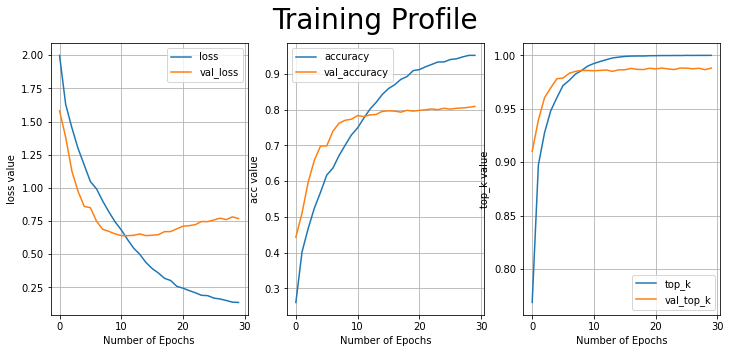

CPU times: user 3min 47s, sys: 1min 3s, total: 4min 51s
Wall time: 4min 38s


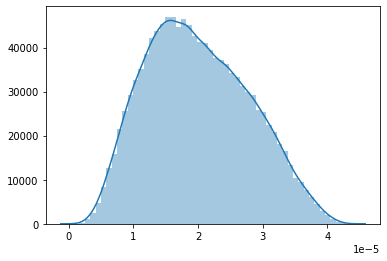

In [18]:
%%time
model.fit(opt='Adam', lr=0.001, decay=0.0, test_batch_size=32,
            train_batch_size=1024, epochs=30, steps_per_epoch=None, recompile = True,
            use_sampling=True, update_sampling=True, reset_sampling=True, sampling_rate=0.5, sampling_relax_epochs=0, sampling_relax_steps=0,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True),
                       ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=5, min_delta=1e-4, min_lr=1e-6, verbose=1)],
            verbose=1)
model.evaluate(model.x_test, model.y_test)
print(max(enumerate(model.history['val_accuracy']),key=lambda x:x[1]))
model.plot(['loss','acc','top_k'])
model.dist()

In [0]:
model.prob_vec.min(), model.prob_vec.max()

(1.4694321306403294e-05, 1.8890877443214976e-05)

In [0]:
1/model.x_train.shape[0]

1.6666666666666667e-05

In [0]:
sns.kdeplot(model.prob_vec)
plt.xscale('log')
plt.yscale('log')

In [0]:
np.argmax(np.arange(5)*5)

4

In [0]:
# # Save model and weights
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'keras_cifar10_trained_model.h5'

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)